# All Imports

In [1]:
import importlib

from app import lib
importlib.reload(lib)
from app import utils
importlib.reload(utils)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers, callbacks
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score, classification_report
#import sagemaker
#from sagemaker.predictor import Predictor

# Globals

In [2]:
# Rate limiter for limiting API requests
RATE_LIMITER = lib.RateLimiter(max_calls_1=lib.MAX_REQUESTS_PER_SECOND, period_1=1, max_calls_2=lib.MAX_REQUESTS_PER_2MINUTE, period_2=140)

In [3]:
#utils.remove_duplicates()
utils.get_features_tc("NA1_5024525952", RATE_LIMITER)

14.5
15.0


True

In [52]:
# Update check
print(utils.updateCheck())

97


# Getting Data

In [53]:
# Get a list of new match_ids
match_ids_list = utils.get_random_match_ids(RATE_LIMITER)

# Convert match_ids_list to dictionary 
match_ids = utils.match_ids_to_dictionary(match_ids_list)

# Store on CSV (Add onto existing matches) 
utils.store_match_ids(match_ids)

Rate limit reached for 100/2m. Sleeping for 121.27 seconds.
Rate limit reached for 100/2m. Sleeping for 121.94 seconds.
Rate limit reached for 100/2m. Sleeping for 121.65 seconds.
Rate limit reached for 100/2m. Sleeping for 121.30 seconds.
Rate limit reached for 100/2m. Sleeping for 122.04 seconds.
Rate limit reached for 100/2m. Sleeping for 120.93 seconds.
Rate limit reached for 100/2m. Sleeping for 120.84 seconds.


# Placing Data Into CSV File

In [4]:
# Use match_ids and extract features
match_ids = utils.read_match_ids()
#print(match_ids)
#match_ids = ['NA1_5024880870', 'NA1_5088501690', 'NA1_5024880870']
#match_ids = ['NA1_5024525952']

# Remove old CSV file if set to true
#if(utils.OVERRIDE_AND_CREATE_NEW_DATA and os.path.isfile(utils.CSV_FILE)):
    #os.remove(utils.CSV_FILE)
    
# Get the data (features, time, and label) from those matches
utils.get_data_15(match_ids, RATE_LIMITER, start_at=5040) 

On this match_id: NA1_5142019947
dupe: matchid already in CSV
On this match_id: NA1_5152026553
dupe: matchid already in CSV
On this match_id: NA1_5152020469
dupe: matchid already in CSV
On this match_id: NA1_5152014458
dupe: matchid already in CSV
On this match_id: NA1_5188327341
On this match_id: NA1_5188202518
On this match_id: NA1_5187318338
On this match_id: NA1_5185517966
On this match_id: NA1_5180243964
On this match_id: NA1_5180218434
On this match_id: NA1_5175108547
dupe: matchid already in CSV
On this match_id: NA1_5175070283
dupe: matchid already in CSV
On this match_id: NA1_5175041875
dupe: matchid already in CSV
On this match_id: NA1_5186932128
On this match_id: NA1_5186911790
On this match_id: NA1_5185859452
On this match_id: NA1_5184234593
On this match_id: NA1_5184209599
On this match_id: NA1_5184170892
On this match_id: NA1_5183601286
On this match_id: NA1_5182028176
On this match_id: NA1_5181916476
On this match_id: NA1_5177780387
dupe: matchid already in CSV
On this m

# Loading Data

In [12]:
df = pd.read_csv("./data/game_data.csv")
df.drop('time', axis=1, inplace=True)
df.drop('match_id', axis=1, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7876 entries, 0 to 7875
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gold_ratio   7876 non-null   float64
 1   xp_ratio     7876 non-null   float64
 2   cs_ratio     7876 non-null   float64
 3   kills_ratio  7876 non-null   float64
 4   win          7876 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 307.8 KB


# Data Prep for AWS SageMaker

In [57]:
# Preprocessing

aws_df = df.copy()
float_vals = ["avg_summoner_lvl_ally", "avg_match_history_length_ally", "avg_win_rate_ally", "avg_summoner_lvl_enemy", "avg_match_history_length_enemy", "avg_win_rate_enemy"]
for col in float_vals:
    aws_df[col] = aws_df[col].round().astype(int)
#print(df[df["sum_champ_mastery_ally"] > 2147483647])
#print(df[df["sum_champ_mastery_enemy"] > 2147483647])
int64_vals = ["sum_champ_mastery_ally", "sum_champ_mastery_enemy", "win"]
for col in int64_vals:
    try:
        aws_df[col] = aws_df[col].astype('int32')
    except Exception as e:
        print(f"Error during conversion: {e}")

# Re-order
label_column = aws_df.columns[-1]
new_column_order = [label_column] + [col for col in aws_df.columns if col != label_column]
aws_df = aws_df[new_column_order]


In [59]:
# Split dataset
train_df, test_df = train_test_split(aws_df, test_size=0.25, random_state=97)

# Save to file
train_df.to_csv('./data/aws_data/game_data_train.csv', index=False, header=False)
test_df.to_csv('./data/aws_data/game_data_test.csv', index=False, header=False)

In [60]:
test_df = pd.read_csv("./data/aws_data/game_data_train.csv")
aws_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   win                             793 non-null    int32
 1   avg_summoner_lvl_ally           793 non-null    int32
 2   avg_match_history_length_ally   793 non-null    int32
 3   avg_win_rate_ally               793 non-null    int32
 4   sum_champ_mastery_ally          793 non-null    int32
 5   avg_summoner_lvl_enemy          793 non-null    int32
 6   avg_match_history_length_enemy  793 non-null    int32
 7   avg_win_rate_enemy              793 non-null    int32
 8   sum_champ_mastery_enemy         793 non-null    int32
dtypes: int32(9)
memory usage: 28.0 KB


# Data Inspection

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7876 entries, 0 to 7875
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gold_ratio   7876 non-null   float64
 1   xp_ratio     7876 non-null   float64
 2   cs_ratio     7876 non-null   float64
 3   kills_ratio  7876 non-null   float64
 4   win          7876 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 307.8 KB


In [8]:
df.head()

,avg_summoner_lvl_ally,avg_match_history_length_ally,avg_win_rate_ally,sum_champ_mastery_ally,avg_summoner_lvl_enemy,avg_match_history_length_enemy,avg_win_rate_enemy,sum_champ_mastery_enemy,win
0,392.2,20.0,0.47,2333535,280.4,20.0,0.45,554507,0
1,154.4,18.6,0.46,744062,285.2,20.0,0.45,263884,1
2,193.4,20.0,0.52,1108563,396.6,20.0,0.43,2218409,1
3,381.0,20.0,0.55,2027703,133.4,20.0,0.53,80786,1
4,281.6,20.0,0.53,301630,223.0,20.0,0.50,474819,1


<Axes: >

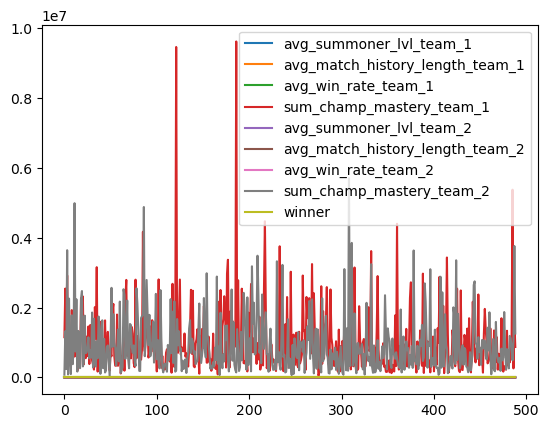

In [160]:
df.plot()

In [50]:
df.describe()

,avg_summoner_lvl_ally,avg_match_history_length_ally,avg_win_rate_ally,sum_champ_mastery_ally,avg_summoner_lvl_enemy,avg_match_history_length_enemy,avg_win_rate_enemy,sum_champ_mastery_enemy,win
count,449.000000,449.000000,449.000000,4.490000e+02,449.000000,449.000000,449.000000,4.490000e+02,449.000000
mean,345.974610,19.809354,0.503519,1.116327e+06,339.873051,19.716704,0.503653,9.972533e+05,0.514477
std,117.587377,0.698724,0.040157,1.130758e+06,109.474887,0.883940,0.042490,8.244530e+05,0.500348
min,86.200000,13.800000,0.350000,8.744600e+04,53.400000,13.800000,0.240000,3.985400e+04,0.000000
25%,258.200000,20.000000,0.480000,4.353360e+05,263.800000,20.000000,0.480000,4.216910e+05,0.000000
50%,334.800000,20.000000,0.500000,7.693630e+05,327.400000,20.000000,0.500000,7.858400e+05,1.000000
75%,433.600000,20.000000,0.520000,1.490250e+06,409.600000,20.000000,0.530000,1.325381e+06,1.000000
max,749.600000,20.000000,0.700000,1.047604e+07,761.800000,20.000000,0.650000,4.987433e+06,1.000000


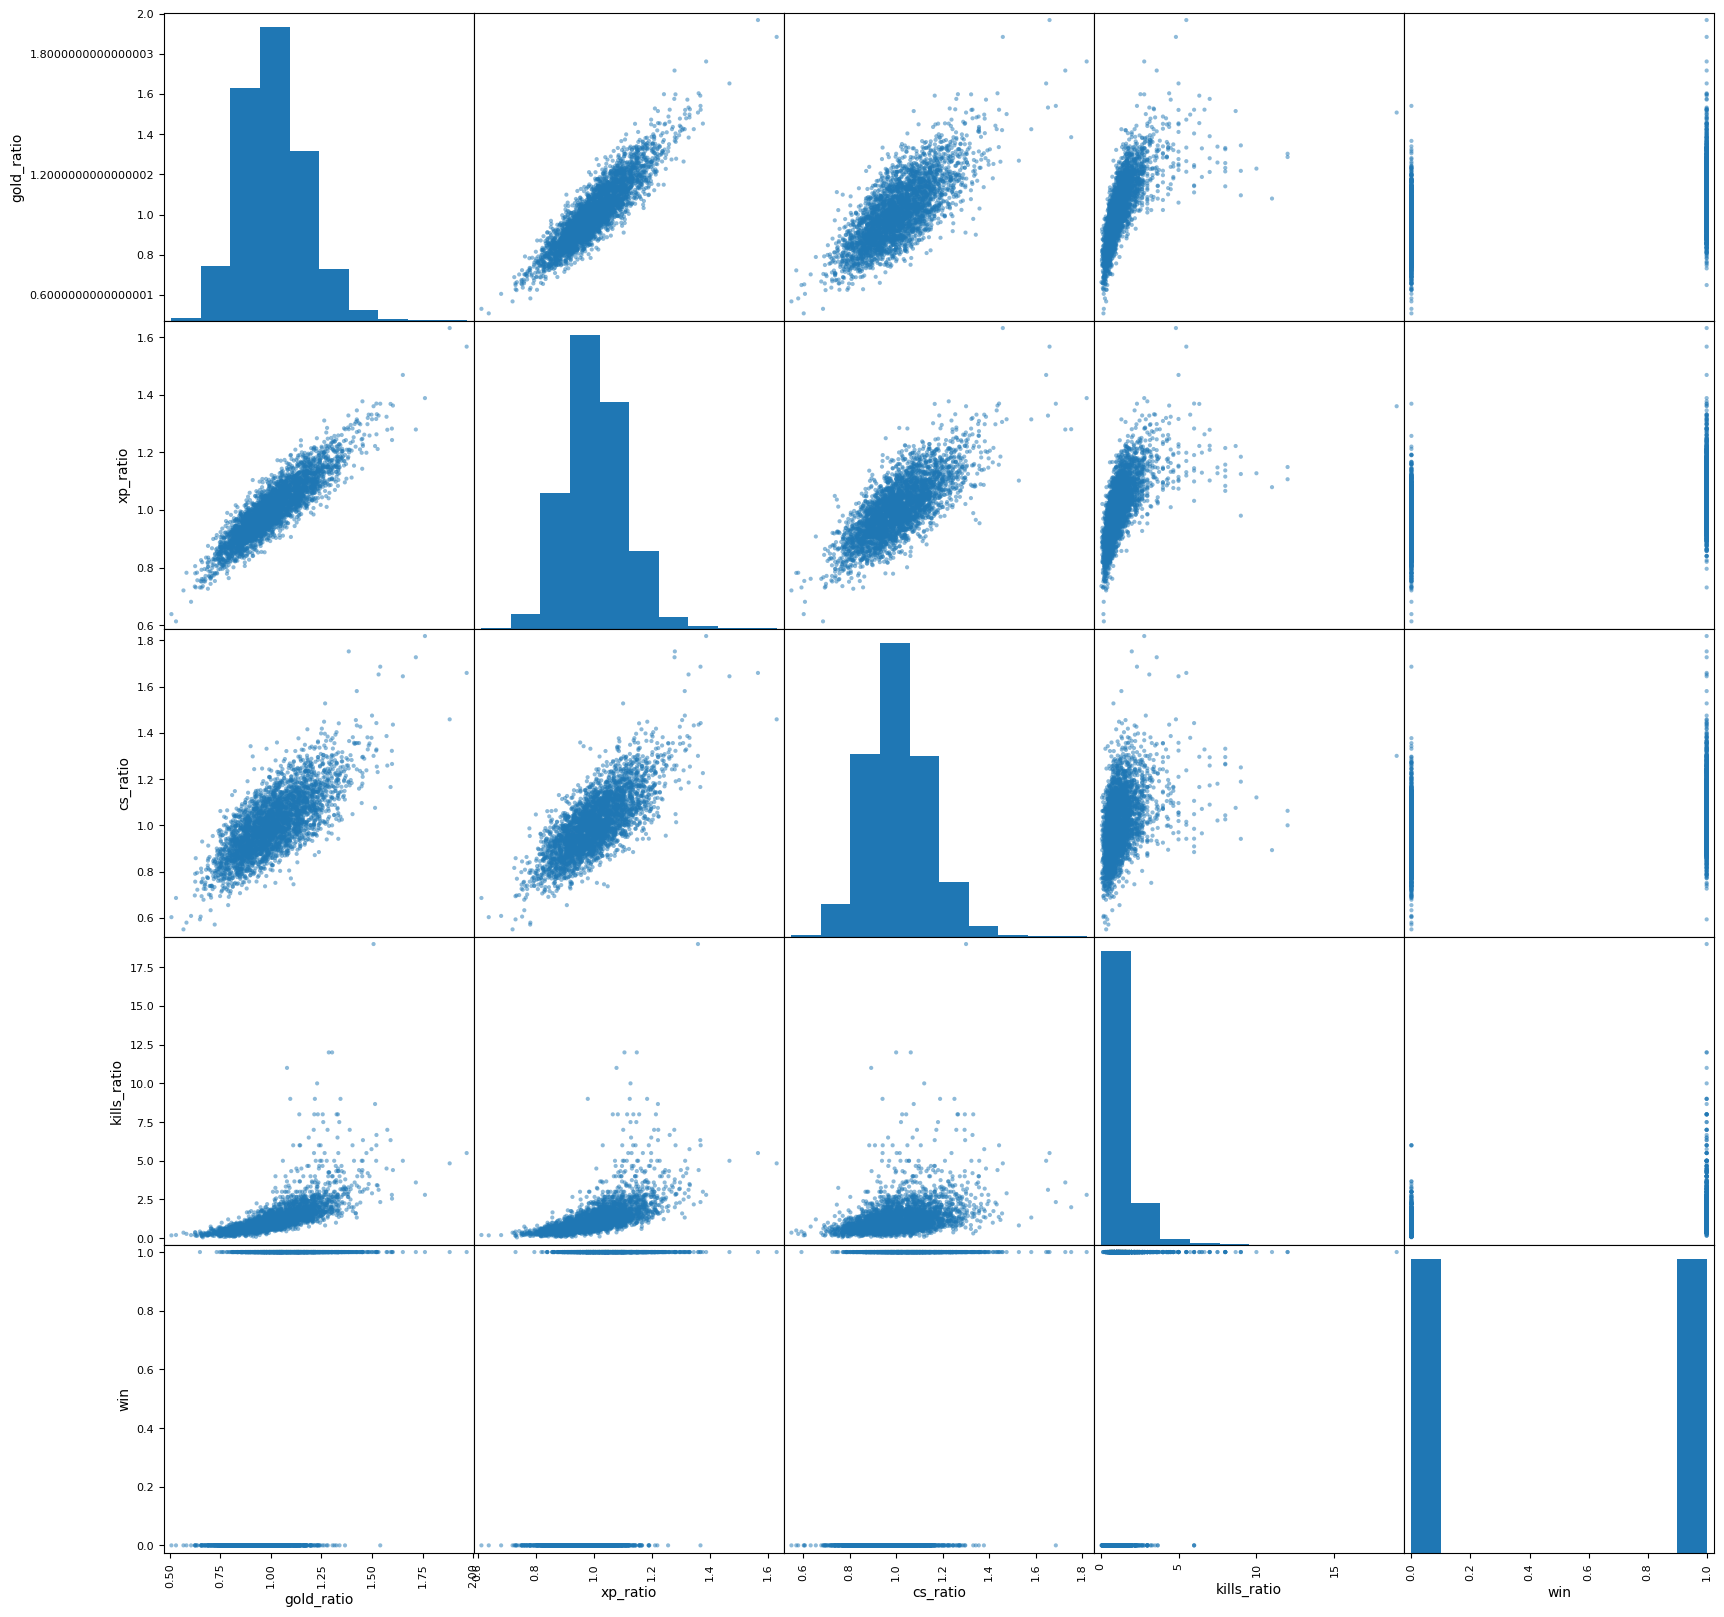

In [56]:
_ = pd.plotting.scatter_matrix(df, figsize=(20,20))

# Training The Model

In [37]:
# X = features
X = df.drop('win', axis=1)
# y = label
y = df['win']

# Standardize data
scaler = MinMaxScaler()
scaler.fit(df)
t_df = scaler.transform(df)

# Split data
X_train, X_test, y_train, y_test = train_test_split(t_df, y, test_size=0.25, random_state=97)
num_features = X_train.shape[1]

# Define model
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(units=64, input_shape=(num_features,), activation='relu', kernel_initializer='he_normal'))

# Add second hidden layer
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))  # Regularization to prevent overfitting

# Output layer
model.add(Dense(units=1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Optimizer
adam = optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=adam, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 0.001 * (0.1 ** (epoch // 20)))

C:\Users\Mensun\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  kernel_constraint: Constraint function applied to


In [38]:
# Training time
model.fit(X_train, y_train, epochs=8, batch_size=32, validation_data=(X_test, y_test)) #, batch_size=14, verbose=1, validation_data=(X_test, y_test)

Epoch 1/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7853 - loss: 0.5295 - val_accuracy: 1.0000 - val_loss: 0.0154
Epoch 2/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0180 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 3/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 6.1632e-04
Epoch 4/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 1.7200e-04
Epoch 5/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 7.6343e-05
Epoch 6/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 3.8688e-05
Epoch 7/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.3301e-04 - val_accuracy: 1.0000 - val_loss: 2.0891e-05
Epoch 8/8
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.3963e-0

# Model Evaulation

In [39]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy * 100:.2f}%')

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.2348e-05
Loss: 1.2114694072806742e-05
Accuracy: 100.00%


# Using Deployment (AWS)

In [86]:
# Ensure Rate limiter for limiting API requests is running

In [3]:
# PLACE SUMMONER_ID HERE
gameName = "Purham"
tagLine = "33333"
summoner_id = utils.get_puuid(gameName, tagLine, RATE_LIMITER)
# Gets the live data
print(utils.get_live_data(summoner_id, RATE_LIMITER))

Error: Data not found
Inserting default champ_mastery, stats: None
{'summoner_id': 'oPVyM8Y6JMx0Ic6NGIiv8HHmvWU3YFYlf6Ie5gNC97P9DJRBWfVdMargcBS43IHeomB3-ildz8RBGQ', 'time': datetime.datetime(2025, 1, 8, 19, 45, 49, 667198), 'avg_summoner_lvl_ally': 445.4, 'avg_match_history_length_ally': 20.0, 'avg_win_rate_ally': 0.49, 'sum_champ_mastery_ally': 178782, 'avg_summoner_lvl_enemy': 309.2, 'avg_match_history_length_enemy': 20.0, 'avg_win_rate_enemy': 0.46, 'sum_champ_mastery_enemy': 1814650, 'win': -1}


In [1]:
"""
import io
#AWS
import io

# Create a DataFrame with your data
df = pd.DataFrame({
    'win':[0],
    '1': [392],
    '2': [20],
    '4': [0.47],
    '5': [2333535],
    '6': [280],
    '7': [20],
    '8': [0.45],
    '9': [554507]
})

# Convert DataFrame to CSV string without header
csv_buffer = io.StringIO()
df.to_csv(csv_buffer, index=False, header=False)  # Exclude header
csv_data = csv_buffer.getvalue()

import boto3

# Initialize a Boto3 client for SageMaker Runtime
client = boto3.client('sagemaker-runtime')

# Define your endpoint name
endpoint_name = 'game-outcomes'

# Make a prediction request
response = client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=csv_data,  # CSV data without headers
    ContentType='text/csv'  # Set content type to CSV
)

# Print the result
print(response['Body'].read().decode())
"""

"\nimport io\n#AWS\nimport io\n\n# Create a DataFrame with your data\ndf = pd.DataFrame({\n    'win':[0],\n    '1': [392],\n    '2': [20],\n    '4': [0.47],\n    '5': [2333535],\n    '6': [280],\n    '7': [20],\n    '8': [0.45],\n    '9': [554507]\n})\n\n# Convert DataFrame to CSV string without header\ncsv_buffer = io.StringIO()\ndf.to_csv(csv_buffer, index=False, header=False)  # Exclude header\ncsv_data = csv_buffer.getvalue()\n\nimport boto3\n\n# Initialize a Boto3 client for SageMaker Runtime\nclient = boto3.client('sagemaker-runtime')\n\n# Define your endpoint name\nendpoint_name = 'game-outcomes'\n\n# Make a prediction request\nresponse = client.invoke_endpoint(\n    EndpointName=endpoint_name,\n    Body=csv_data,  # CSV data without headers\n    ContentType='text/csv'  # Set content type to CSV\n)\n\n# Print the result\nprint(response['Body'].read().decode())\n"